This example was done using Datalab. You can read and use the Python code in other environments if you have never used Datalab before. For example, we used a path to a file in gs://, but you can also just copy that file to your environment and use a local path instead.

This example is for **advanced** users who want to understand the data representation. **You do NOT need to understand this in order to use DeepVariant.**

If you want to run this Datalab interactively:

1. Follow Quickstart for Datalab: https://cloud.google.com/datalab/docs/quickstarts 
1. Once follow the Quickstart and you have Datalab directory tree open in your browser, download this file.
1. Upload it to your Datalab environment. Then, you can open the Datalab notebook and step through the cells. This notebook should give you a good starting point to understand the format.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import tensorflow as tf
from tensorflow.core.example import example_pb2


In [2]:
def read_tfrecords(path, max_records=None):
    """Yields the parsed records in tfrecord formatted file path.

    Args:
        path: String. A path to a tfrecord formatted file containing tensorflow.Example.
        max_records: int >= 0 or None. Maximum number of records to read from path.
          If None, the default, all records will be read.

    Yields:
        tensorflow.Example on each record in path in order.
    """
    proto = example_pb2.Example
    options = tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)
    i = 0
    for buf in tf.python_io.tf_record_iterator(path, options):
        i += 1
        if max_records is not None and i > max_records:
            return
        yield proto.FromString(buf)

def get_bytes_list(example, key):
    """Returns the bytes-list corresponding to a key in a tf.Example."""
    return example.features.feature[key].bytes_list.value


def get_int64_list(example, key):
    """Returns the int64-list corresponding to a key in a tf.Example."""
    return example.features.feature[key].int64_list.value

def get_label(example):
    """Returns the label(class) of the example. Expected values are 0 (HOM-REF), 1(HET), 2(HOM-ALT)"""
    return get_int64_list(example, 'label')[0]

def imshows(images, labels=None, n=None, scale=10, axis='off', write=False, img_title='', **kwargs):
    """Plots a list of images in a row.

    Args:
        images: List of image arrays.
        labels: List of str or None. Image titles.
        n: int or None. How many images in the list to display. If this is None,
          display all of them.
        scale: int. How big each image is.
        axis: str. How to plot each image.
        **kwargs: Keyword arguments for Axes.imshow.
    Returns:
        None.
    """
    n = len(images) if (n is None) else n
    with sns.axes_style('white'):
        _, axs = plt.subplots(1, n, figsize=(n * scale, scale))
        for i in xrange(n):
            axs[i].imshow(images[i], **kwargs)
            axs[i].axis(axis)
            if labels:
                axs[i].set_title(labels[i])
        plt.show()
    if write:
        for i in xrange(n):
            plt.imsave(arr=images[i], fname=labels[i]+img_title+'.png')

def visualize_example(example, write=False, img_title=''):
    # Read in the image bytestring and its shape: [100, 221, 6].
    image = get_bytes_list(example, 'image/encoded')[0]
    shape = (100, 221, 6)
    # Parse the bytestring and reshape to an image.
    image = np.frombuffer(image, np.uint8).reshape(shape)
    # Split the tensor by its channels dimension and plot.
    channels = [image[:, :, i] for i in range(shape[-1])]
    # Prepend an image: RGBA image reconstructed from the 6-channels
    channels.insert(0, channels_to_rgb(image))
    titles = ["reconstructed RGBA (label=%s)" % get_label(example),
              "read base", "base quality", "mapping quality", "strand",
              "supports variant", "supports reference"]
    imshows(channels, titles, axis="image", write=write, img_title=img_title,scale=5)
    
def channels_to_rgb(image):
    # Read in the image bytestring and its shape: [100, 221, 6].
    image = get_bytes_list(example, 'image/encoded')[0]
    shape = (100, 221, 6)
    # Parse the bytestring and reshape to an image.
    image = np.frombuffer(image, np.uint8).reshape(shape)

    # Split the tensor by its channels dimension and parse.
    channels = [image[:, :, i] for i in range(shape[-1])]
    # Reconstruct the original channels
    base = channels[0]
    qual = np.minimum(channels[1], channels[2])
    strand = channels[3]
    alpha = np.multiply(
        channels[4] / 254.0,
        channels[5] / 254.0)
    return np.multiply(
        np.stack([base, qual, strand]),
        alpha).astype(np.uint8).transpose([1, 2, 0])


# Visualize examples

The following cell reads tf.train.Example protos from a source. This source is in gzipped TFRecord format. We show a few examples, including:

Visualize the 6-tensor that represent 6 different features.
Reconstruct the RGBA image representation and render it as one image defined in the supplementary materials [here](https://doi.org/10.1101/092890).


In [3]:
# This tfrecord comes from HG002 PFDA data. I ran make_examples in training mode so we also have the labels.
src = 'examples.tfrecord.gz'

# Convert the generator to a list for easy access.
# If you increase the number of max_records, you might not want to convert it to a list.
examples = list(read_tfrecords(src, 5))


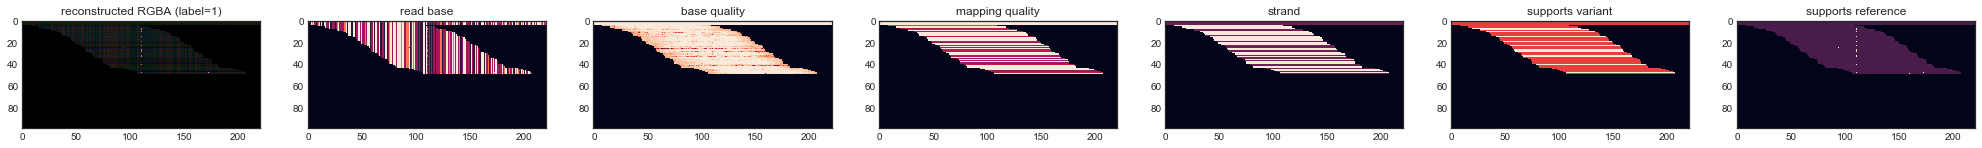

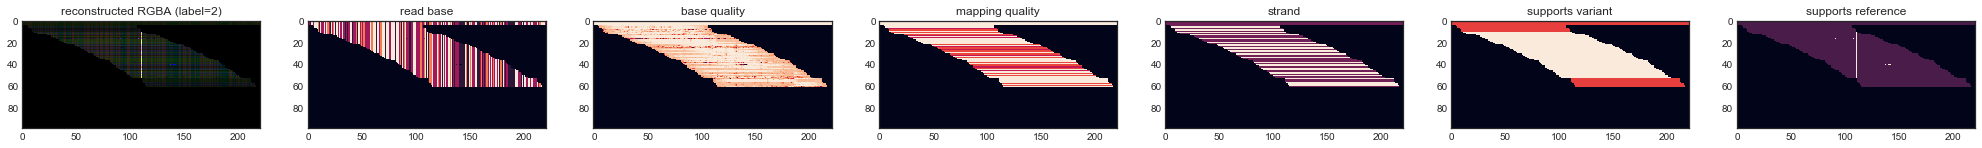

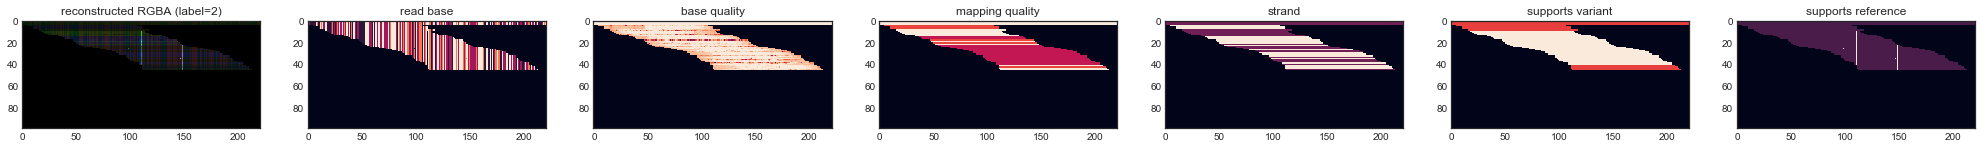

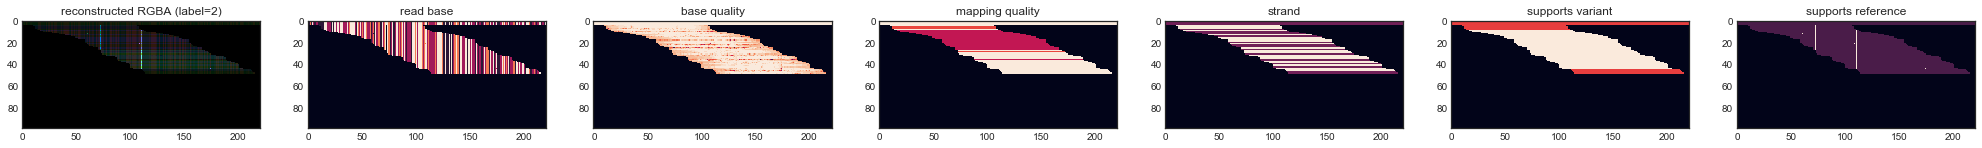

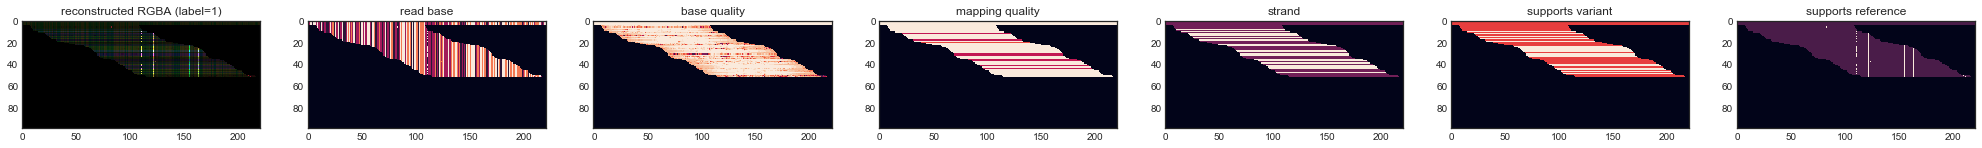

In [6]:
# After you run this cell, images should show up.
i = 0;
for example in examples:
    visualize_example(example, True, str(i))
    i += 1
